# Trabalho Prático 1 - Aprendizado de Máquina

Frederico Dolher Souza Baker

fredericobaker@dcc.ufmg.br

Matrícula: 2021031513

29/05/2024

[Link do repositório](https://github.com/FredericoBaker/rede-neural-mnist)

Neste notebook, será implementada uma rede neural com três camadas com o objetivo de classificar as imagens do dataset MNIST, que contém 5000 imagens de díginos escritos manualmente, de acordo com o número que elas representam. A rede construída tem a seguinte estrutura:

1. **Camada de Entrada:** Como as imagens do MNIST tem dimensão 28x28, a camada de entrada possuirá 784 unidades.
2. **Camada Oculta:** Serão testadas 25, 50 e 100 unidades.
3. **Camada de Saída:** Cada uma das unidades representará a probabilidade de uma dada imagem ser de um dígito em questão. Logo, teremos 10 unidades na saída.

A função de ativação usada foi a **Sigmóide** e a função de perda a ser minimizada é a Cross-Entropy Loss. 

Além disso, três diferentes algoritmos para o cálculo do gradiente foram comparados:

1. **Gradient Descent:** Gradiente é calculado após todas as entradas serem processadas.
2. **Stochastic Gradient Descent:** A cada entrada processada o gradiente é calculado.
3. **Mini-Batch Gradient Descent:** O gradiente é calculado após certo número de entradas processadas. Aqui testamos mini-batches de tamanho 10 e 50.

A taxa de aprendizado será variada entre 0.5, 1 e 10 para analisar o impacto dela na convergência da rede.

A partir dessas definições e hiperparâmetros foi realizado um grid search para definir a melhor combinação de hiperparâmetros para esse problema.

## Implementação

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
class MNISTDataset(Dataset):
    """
    Classe que representa um dataset customizado para o conjunto de dados MNIST.
    """
    
    def __init__(self, file):
        data = pd.read_csv(file, header=None)
        self.labels = data.iloc[:, 0].values  # Extrai os rótulos (primeira coluna)
        self.images = data.iloc[:, 1:].values / 255.0  # Extrai as imagens (restante das colunas) e normaliza os valores para o intervalo [0, 1]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [159]:
dataset = MNISTDataset('data_tp1.csv')

# Calcula o tamanho dos conjuntos de treinamento, validação e teste
train_size = int(0.7 * len(dataset))  # 70% dos dados para treinamento
val_size = int(0.15 * len(dataset))   # 15% dos dados para validação
test_size = len(dataset) - train_size - val_size  # O restante (15%) para teste

# Divide o dataset em conjuntos de treinamento, validação e teste com os tamanhos calculados
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Cria DataLoaders para cada conjunto com um batch size de 5000 e embaralhamento dos dados ativado
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=True)

In [160]:
class NeuralNetwork(nn.Module):
    """
    Classe que define uma rede neural simples com uma camada oculta e uma função de ativação sigmoide.
    """
    def __init__(self, input_size, num_hidden, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_size, num_hidden) 
        self.sigmoid = nn.Sigmoid()
        self.layer_2 = nn.Linear(num_hidden, num_classes)
    
    def forward(self, x):
        out = self.layer_1(x)  # Aplica a primeira camada
        out = self.sigmoid(out)  # Aplica a função de ativação sigmoide
        out = self.layer_2(out)  # Aplica a segunda camada
        return out

def weights_init(m):
    """
    Inicializa os pesos das camadas da rede neural usando o método de Xavier (uniforme).
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight) 
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [161]:
def evaluate_model(model, loss_criterion, loader):
    """
    Avalia o desempenho de um modelo em termos de perda e acurácia.
    """
    model.eval()  # Coloca o modelo em modo de avaliação
    loss = 0.0 
    correct = 0 
    total = 0 
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss += loss_criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(loader)  # Calcula a perda média
    accuracy = correct / total
    return loss, accuracy


In [162]:
def train_model(model, loss_criterion, optimizer, train_loader, val_loader, num_epochs):
    """
    Treina um modelo de rede neural e avalia seu desempenho em dados de validação.
    """
    model.train()  # Coloca o modelo em modo de treinamento
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step() 
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)  # Calcula a perda média da época
        train_loss_history.append(epoch_loss)

        # Avalia o modelo nos dados de validação
        val_loss, val_accuracy = evaluate_model(model, loss_criterion, val_loader)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_loss_history, val_loss_history, val_accuracy_history


## Grid Search

In [164]:
# Definição dos parâmetros para o grid search
hidden_units_list = [25, 50, 100] 
learning_rates = [0.5, 1, 10]
batch_sizes = [1, 10, 50, 5000]  # SGD, Mini-Batch (10, 50), Full-Batch
epochs = 50

# Cria um produto cartesiano dos parâmetros para o grid search
grid_search = itertools.product(hidden_units_list, learning_rates, batch_sizes)

results = {}

for hidden_units, lr, batch_size in grid_search:
    print(f'\nTraining with: hidden_units={hidden_units}, lr={lr}, batch_size={batch_size}')
    
    model = NeuralNetwork(input_size=784, num_hidden=hidden_units, num_classes=10)
    model.apply(weights_init)

    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr) 
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    train_loss_history, val_loss_history, val_accuracy_history = train_model(model, loss_criterion, optimizer, train_loader, val_loader, epochs)
    
    key = f'hidden_units={hidden_units}_lr={lr}_batch_size={batch_size}'
    
    results[key] = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'val_accuracy': val_accuracy_history
    }

# Salva os resultados em um arquivo pickle
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)



Training with: hidden_units=25, lr=0.5, batch_size=1
Epoch [1/50], Train Loss: 1.1377, Validation Loss: 0.9206, Validation Accuracy: 0.6987
Epoch [2/50], Train Loss: 0.8479, Validation Loss: 0.9650, Validation Accuracy: 0.6920
Epoch [3/50], Train Loss: 0.7396, Validation Loss: 0.6466, Validation Accuracy: 0.8187
Epoch [4/50], Train Loss: 0.6369, Validation Loss: 0.6275, Validation Accuracy: 0.8067
Epoch [5/50], Train Loss: 0.6425, Validation Loss: 0.6255, Validation Accuracy: 0.8267
Epoch [6/50], Train Loss: 0.5860, Validation Loss: 0.7669, Validation Accuracy: 0.8013
Epoch [7/50], Train Loss: 0.5939, Validation Loss: 0.6043, Validation Accuracy: 0.8320
Epoch [8/50], Train Loss: 0.4756, Validation Loss: 0.5460, Validation Accuracy: 0.8573
Epoch [9/50], Train Loss: 0.4548, Validation Loss: 0.6269, Validation Accuracy: 0.8240
Epoch [10/50], Train Loss: 0.4538, Validation Loss: 0.6366, Validation Accuracy: 0.8187
Epoch [11/50], Train Loss: 0.4173, Validation Loss: 0.4254, Validation Accu

## Análise dos Resultados

In [ ]:
# Carrega os resultados obtidos no grid search
with open("results.pkl", "rb") as f:
    results = pickle.load(f)

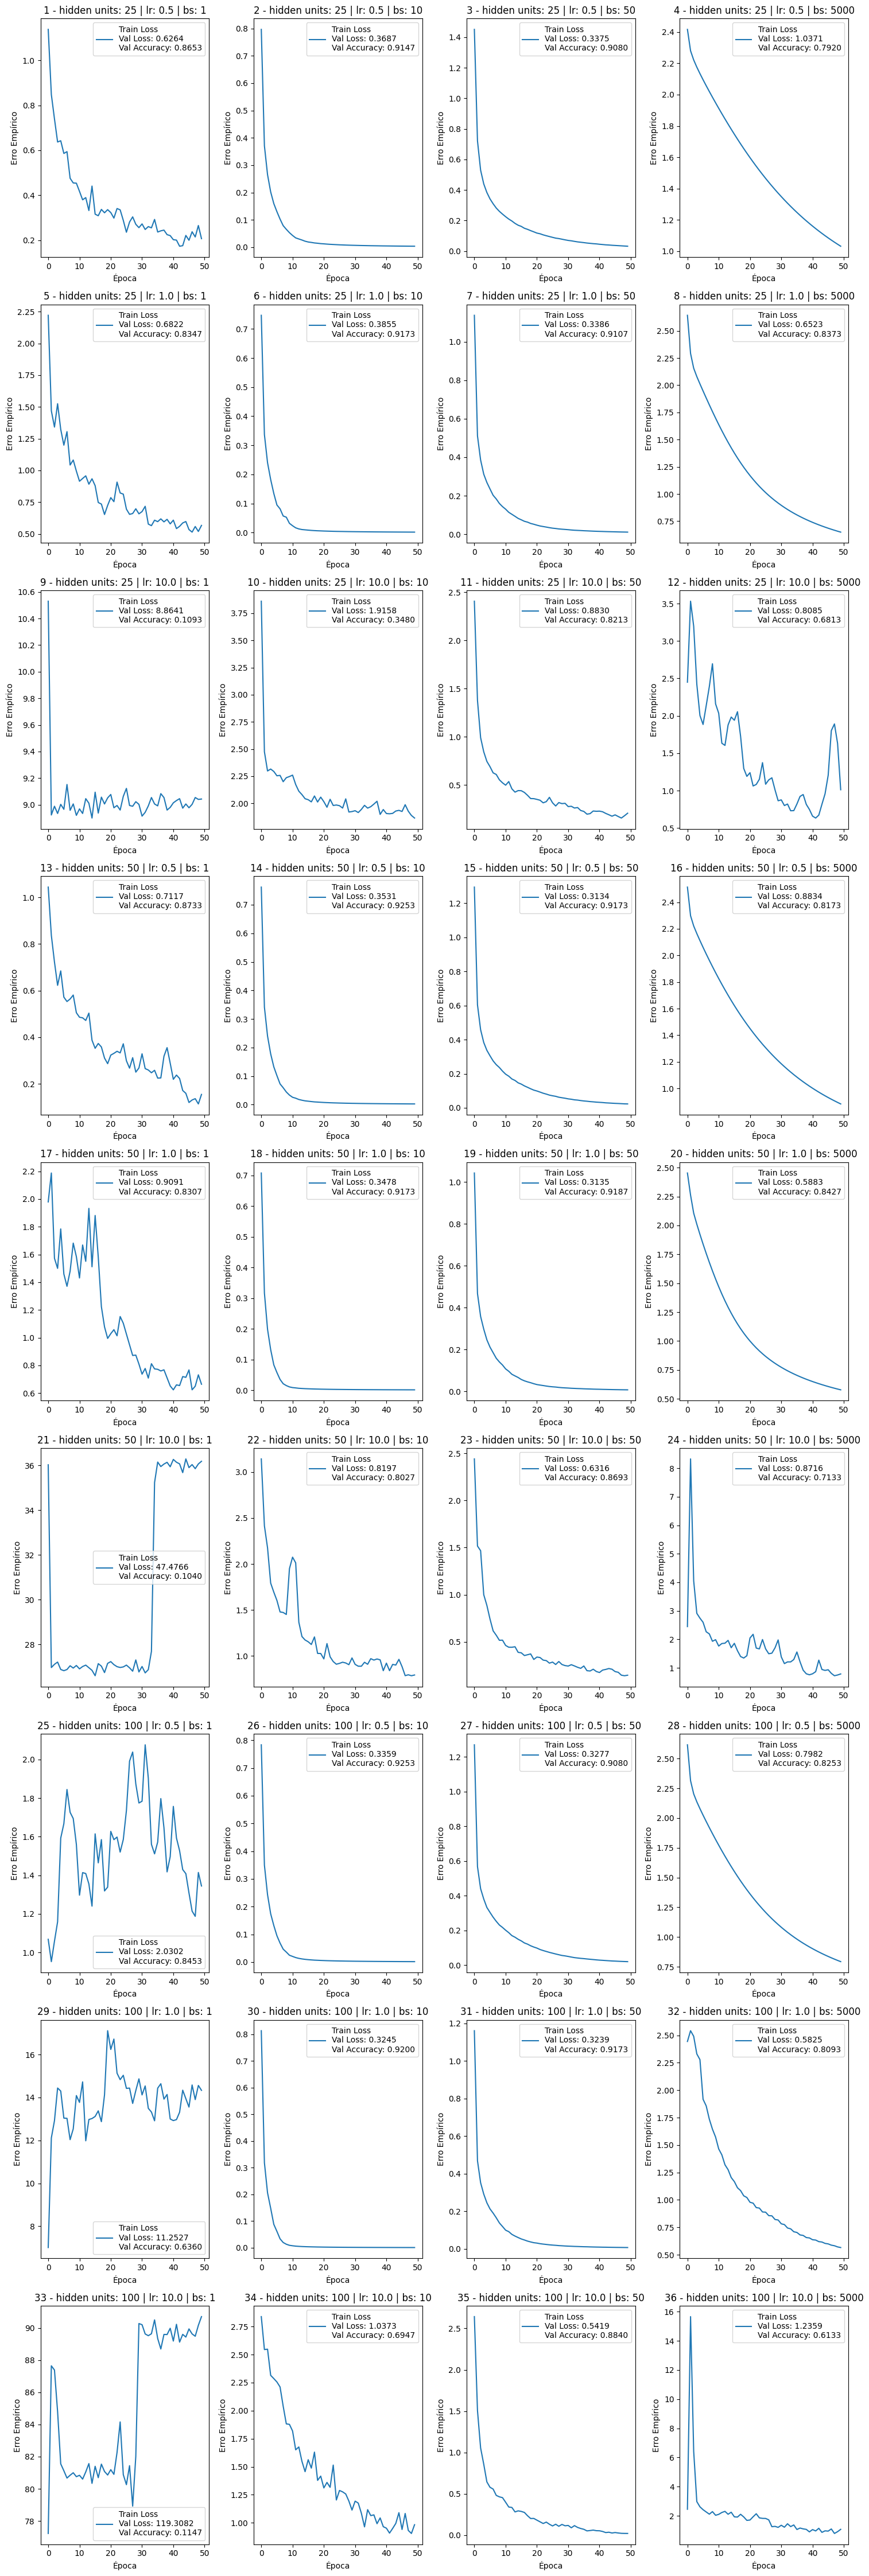

In [176]:
num_combinations = len(results)
num_cols = 4
num_rows = round(num_combinations / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, (key, value) in enumerate(results.items()):
    train_loss_history = value['train_loss']
    hidden_units, lr, batch_size = [float(x.split('_')[0]) for x in key.split('=')[1:]]

    final_val_loss = value['val_loss'][-1]
    final_val_accuracy = value['val_accuracy'][-1]
    
    axes[i].plot(train_loss_history, label=f'Train Loss\nVal Loss: {final_val_loss:.4f}\nVal Accuracy: {final_val_accuracy:.4f}')
    axes[i].set_title(f'{i+1} - hidden units: {int(hidden_units)} | lr: {lr} | bs: {int(batch_size)}')
    axes[i].set_xlabel('Época')
    axes[i].set_ylabel('Erro Empírico')
    axes[i].legend()

plt.tight_layout()
plt.show()

A partir dos gráficos acima, fica evidente como as diferentes combinações de hiperparâmetros impactam o treinamento da rede neural de maneiras distintas. A seguir, analisamos como a variação de cada hiperparâmetro afeta o aprendizado.

### Número de unidades na camada oculta

**Impacto**

 - __25 Unidades:__ A rede consegue aprender e reduzir o erro de treino de forma consistente. Entretanto, a acurácia no conjunto de validação parece ser bastante sensível aos outros hiperparâmetros.
 - __50 Unidades:__ Em comparação com a rede de 25 unidades, há uma melhora geral, com um erro de treino menor e uma acurácia de validação ligeiramente maior.
 - __100 Unidades:__ A performance melhora ainda mais, exceto quando usados tamanhos de batch baixos, onde o erro empírico aumenta drasticamente, resultando em um desempenho ruim.

**Motivo**

Aumentar o número de unidades na camada oculta aumenta a complexidade da mesma e, por consequência, a capacidade dela de capturar nuances nos dados, melhorando potencialmente a performance. No entanto, há um risco de overfitting, especialmente em redes com 100 unidades na camada oculta, onde o erro de treino parece diminuir rapidamente, mas a acurácia de validação não mostra uma melhora correspondente. Além disso, redes com mais unidades na camada oculta têm uma função de perda mais complexa, com mais mínimos locais, o que pode levar a explosões no erro empírico, como observado nos gráficos 21, 25, 29 e 33. Isso ocorre porque a função de perda mais complexa pode fazer com que o gradiente siga uma direção não ideal.


### Taxa de aprendizado

**Impacto**

 - __0.5:__ Com essa taxa de aprendizado, o erro de treino reduz de maneira suave e consistente, sem saltos grandes. Essa taxa também apresenta alguns dos melhores resultados de acurácia.
 - __1.0:__ A taxa de aprendizado igual a 1.0 acelera a convergência do erro empírico, mas apresenta uma oscilação maior, especialmente quando o tamanho de batch é pequeno.
 - __10:__ Essa taxa de aprendizado resulta em instabilidade no treinamento. O erro empírico sofre grandes saltos e, em geral, não atinge bons resultados, sendo a mais propensa a fazer com que o erro exploda.

**Motivo**

A taxa de aprendizado regula o tamanho do passo dado cada vez que os pesos são ajustados. Uma taxa baixa é mais conservadora e segue lentamente para um mínimo, mas é menos propensa a fazer o erro explodir. Uma taxa alta dá passos maiores, acelerando a convergência, mas aumenta o risco de explosão do erro. Portanto, uma taxa intermediária, como 0.5 ou 1.0, parece ser mais adequada, proporcionando um bom equilíbrio entre velocidade de convergência e estabilidade.


### Tamanho do batch

**Impacto**

 - __1 (SGD):__ A perda diminui de forma mais ruidosa, pois a amostra usada para calcular o gradiente pode ser enviesada. Esse tamanho de batch apresentou os piores resultados, com erros explodindo em muitos casos e uma acurácia de validação geralmente baixa.
 - __10 e 50 (Mini-Batch):__ Esses tamanhos de batch apresentam uma convergência mais equilibrada e rápida, com o erro atingindo valores baixos em poucas épocas. Eles também alcançam uma acurácia de classificação alta.
 - __5000 (Full-Batch):__ No full batch, o erro empírico diminui de forma muito suave, mas é muito lento para atingir a convergência. Em muitos casos, a rede não chega a convergir totalmente nas 50 épocas, necessitando de mais épocas para convergir.

**Motivo**

Quanto menor o tamanho do batch, maior a variância das atualizações dos gradientes, e mais rápida a convergência pode ser. Batches pequenos introduzem mais ruído nos gradientes, o que pode ajudar a escapar de mínimos locais, mas também pode fazer o erro explodir. Batches muito grandes proporcionam gradientes mais estáveis, mas são caros computacionalmente e levam mais épocas para convergir. Como observado nos gráficos, tamanhos de batch intermediários, como 10 e 50, oferecem um bom equilíbrio entre os benefícios dos batches pequenos e grandes, minimizando seus aspectos negativos.



Sendo assim, vamos escolher a combinação de parâmetros que chegou ao menor erro de validação.

In [177]:
# Selecionar o melhor conjunto de hiperparâmetros baseado no menor erro de validação
best_model_key = min(results, key=lambda k: min(results[k]['val_loss']))
best_model_results = results[best_model_key]

print(f'Best model hyperparameters: {best_model_key}')

Best model hyperparameters: hidden_units=50_lr=1_batch_size=10


Agora vamos treinar o modelo com esses parâmetros no conjunto de treino e validação juntos e posteriormente testá-lo no conjunto de teste.

In [185]:
# Treinar novamente o melhor modelo usando os dados de treino e validação juntos
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=5000, shuffle=True)
best_hidden_units, best_lr, best_batch_size = [float(x.split('_')[0]) for x in best_model_key.split('=')[1:]]
best_model = NeuralNetwork(input_size=784, num_hidden=int(best_hidden_units), num_classes=10)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(best_model.parameters(), lr=best_lr)
train_loss_history, _, _ = train_model(best_model, loss_criterion, optimizer, combined_loader, test_loader, num_epochs=200)

# Avaliar o melhor modelo no conjunto de teste
test_loss, test_accuracy = evaluate_model(best_model, loss_criterion, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/200], Train Loss: 2.3420, Validation Loss: 2.2911, Validation Accuracy: 0.1640
Epoch [2/200], Train Loss: 2.2900, Validation Loss: 2.2642, Validation Accuracy: 0.1107
Epoch [3/200], Train Loss: 2.2587, Validation Loss: 2.2395, Validation Accuracy: 0.2480
Epoch [4/200], Train Loss: 2.2344, Validation Loss: 2.2155, Validation Accuracy: 0.2680
Epoch [5/200], Train Loss: 2.2091, Validation Loss: 2.1889, Validation Accuracy: 0.3720
Epoch [6/200], Train Loss: 2.1817, Validation Loss: 2.1598, Validation Accuracy: 0.4413
Epoch [7/200], Train Loss: 2.1514, Validation Loss: 2.1274, Validation Accuracy: 0.4867
Epoch [8/200], Train Loss: 2.1178, Validation Loss: 2.0915, Validation Accuracy: 0.5240
Epoch [9/200], Train Loss: 2.0803, Validation Loss: 2.0516, Validation Accuracy: 0.5640
Epoch [10/200], Train Loss: 2.0388, Validation Loss: 2.0077, Validation Accuracy: 0.5827
Epoch [11/200], Train Loss: 1.9930, Validation Loss: 1.9599, Validation Accuracy: 0.5960
Epoch [12/200], Train Loss: 1.

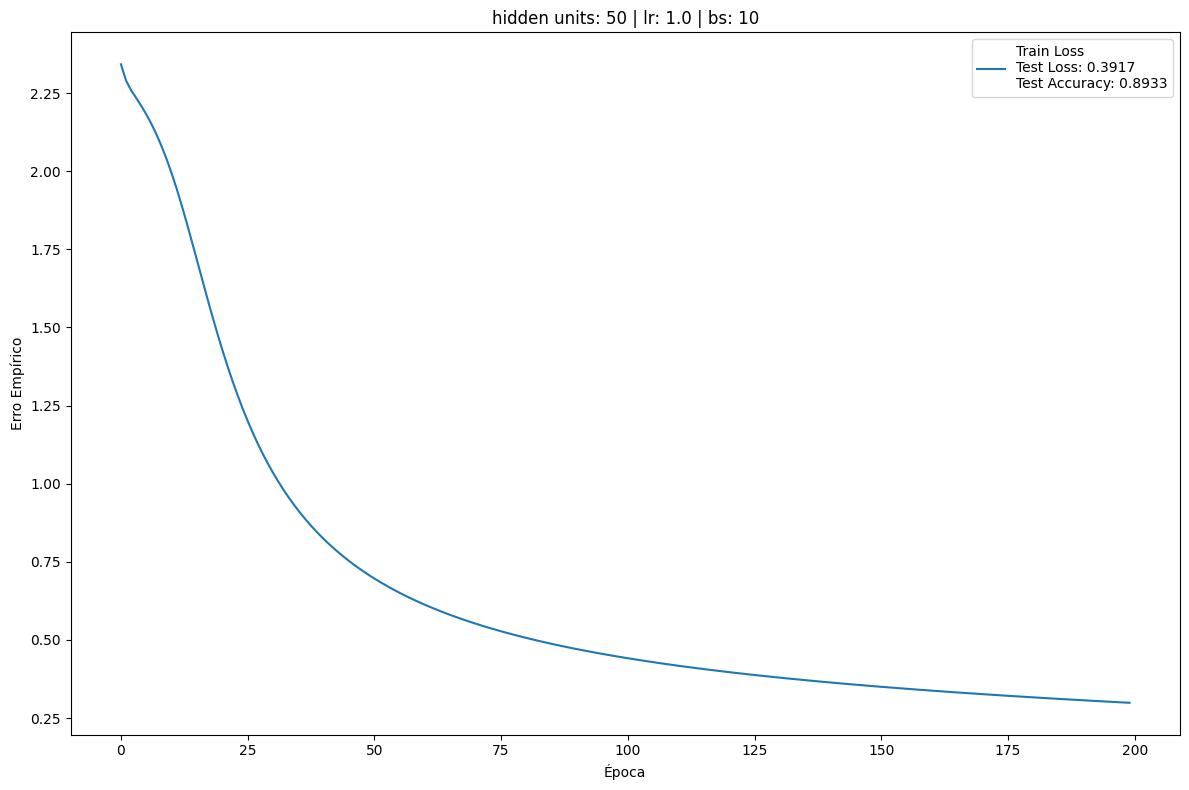

In [187]:
plt.figure(figsize=(12,8))

plt.plot(train_loss_history, label=f'Train Loss\nTest Loss: {test_loss:.4f}\nTest Accuracy: {test_accuracy:.4f}')
plt.title(f'hidden units: {int(best_hidden_units)} | lr: {best_lr} | bs: {int(best_batch_size)}')
plt.xlabel('Época')
plt.ylabel('Erro Empírico')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusão

Conforme esperado, o modelo que alcançou o menor erro de validação foi aquele cujos hiperparâmetros ofereceram um bom equilíbrio entre os benefícios e os malefícios. A melhor combinação encontrada foi a de 50 unidades na camada oculta, taxa de aprendizado igual a 1 e tamanho de batch igual a 10. Esse modelo atingiu uma perda no conjunto de teste igual a 0.3917 e uma acurácia de 0.8933. Esses resultados mostram que a escolha cuidadosa dos hiperparâmetros é crucial para o desempenho ótimo de redes neurais, evitando problemas como overfitting e instabilidade no treinamento.